## Load libraries

In [2]:
library(tidyverse)
library(anomalize)

## Load Data

In [16]:
df = read.csv("../../data/NYCHA_TS.csv")
df = df[, c('Building_Meter', 'Month', 'Imputed_KWH')]

In [17]:
tb = read_csv("../../data/NYCHA_TS.csv")
tb = select(tb, c('Building_Meter', 'Month', 'Imputed_KWH'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Building_Meter = col_character(),
  Month = col_date(format = ""),
  Month_Type = col_character(),
  `Month_#_Days` = col_double(),
  Prorated_Days = col_double(),
  Gap_Days = col_double(),
  Gap_Type = col_character(),
  Prorated_KWH = col_double(),
  Imputed_KWH = col_double()
)


## Testing Twitter's AnomalyDetection package

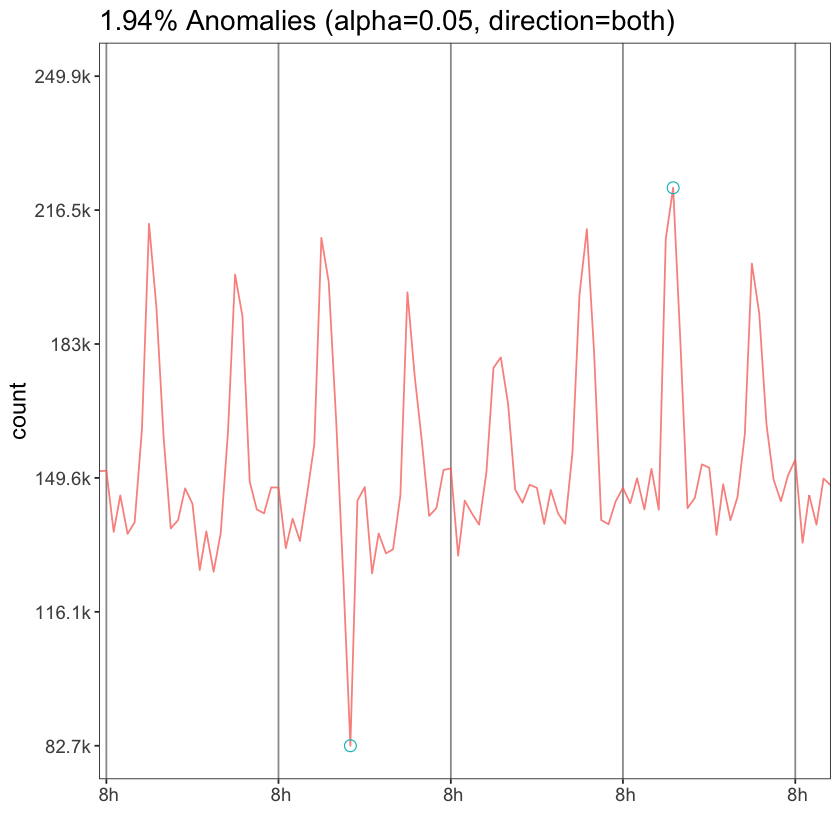

In [6]:
ts = select(filter(df, Building_Meter == '165.0 - BLD 03_90327795'), 'Month', 'Imputed_KWH')
ts$Month = as.POSIXct(as.character(ts$Month))

res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=TRUE)
res$plot

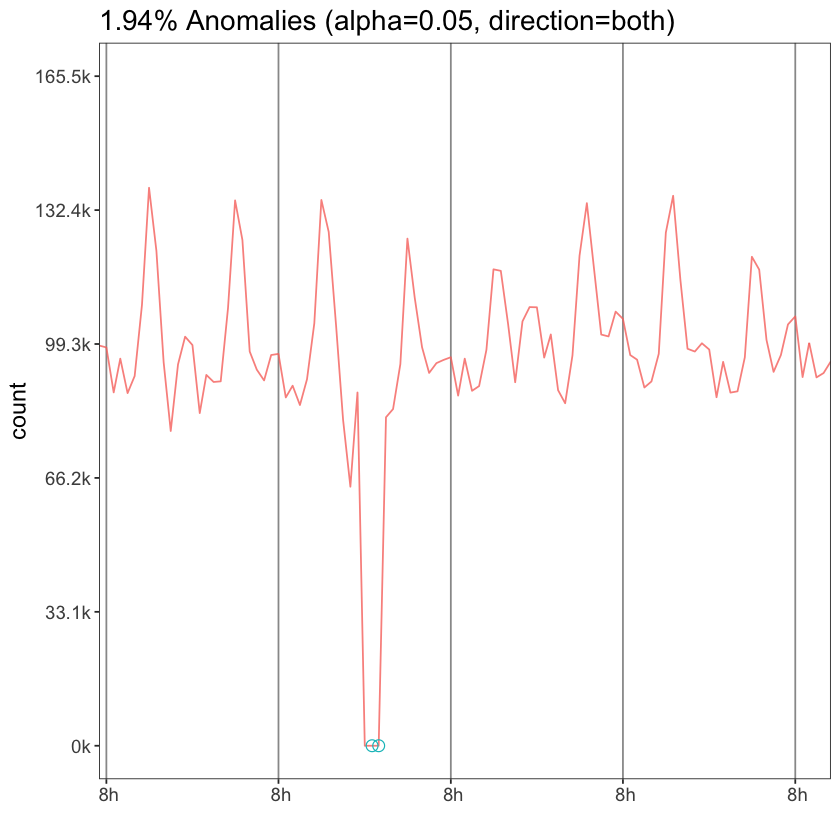

In [7]:
ts = select(filter(df, Building_Meter == '164.0 - BLD 01_96973681'), 'Month', 'Imputed_KWH')
ts$Month = as.POSIXct(as.character(ts$Month))

res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=TRUE)
res$plot

## Exploring the STL function from stats package

In [49]:
require(graphics)

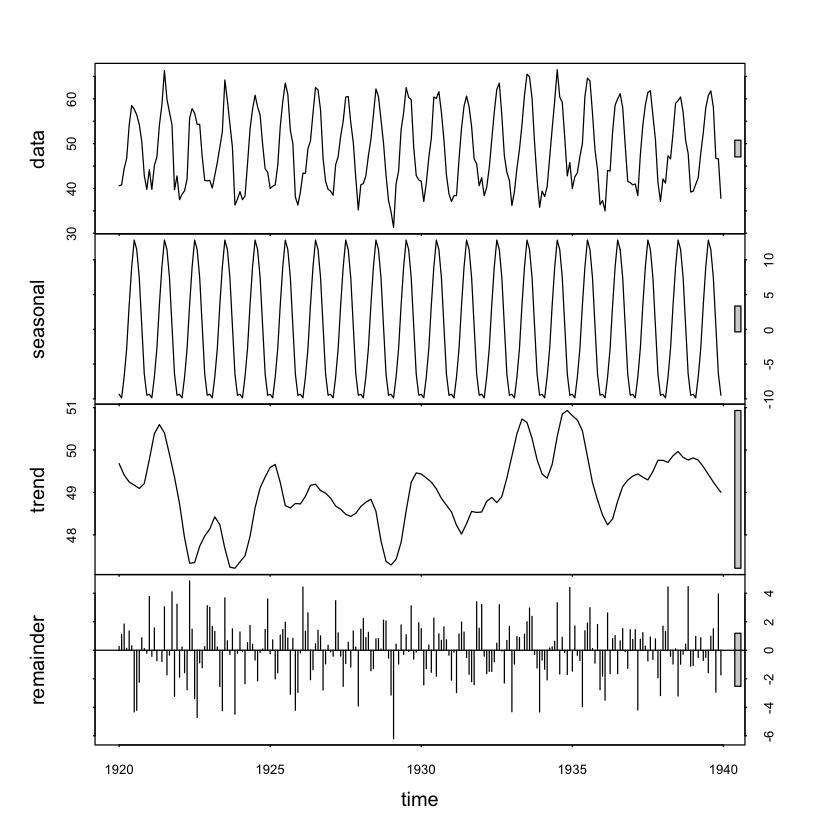

In [50]:
plot(stl(nottem, "per"))

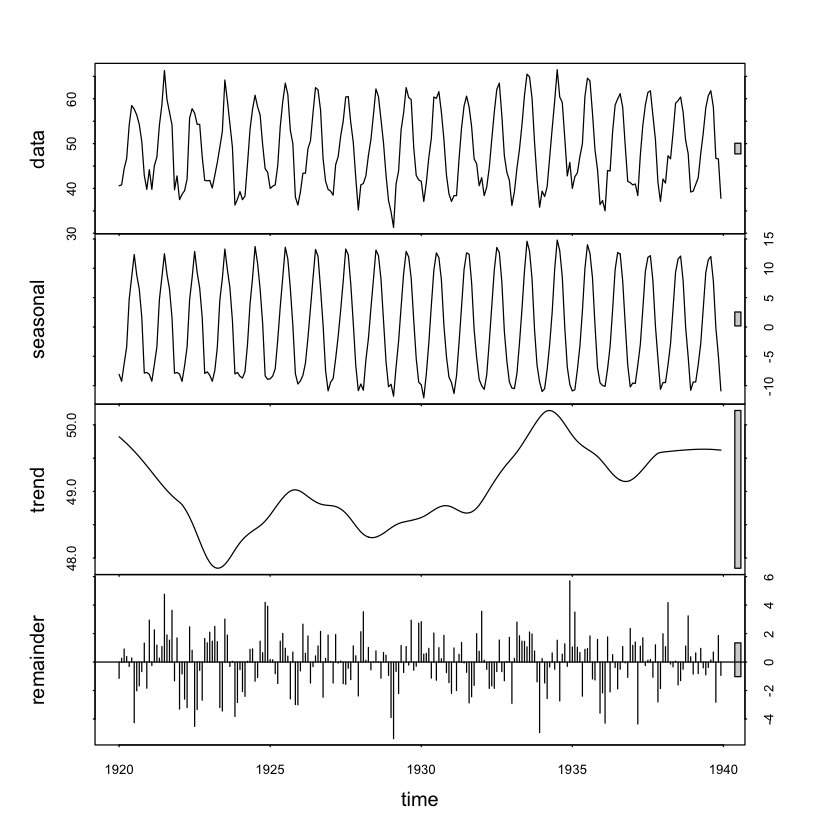

In [51]:
plot(stl(nottem, s.window = 7, t.window = 50, t.jump = 1))

## Exploring the Anomalize package

#### Example 1 - no missing data

In [8]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, merge = TRUE) %>%
    anomalize(remainder) %>%
    time_recompose()

ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


Observations: 103
Variables: 11
$ Month         <date> 2009-12-01, 2010-01-01, 2010-02-01, 2010-03-01, 2010-0…
$ Imputed_KWH   <dbl> 151280.0, 151382.9, 136106.8, 145211.0, 135622.2, 13849…
$ observed      <dbl> 151280.0, 151382.9, 136106.8, 145211.0, 135622.2, 13849…
$ season        <dbl> -5292.352, -4686.829, -20499.522, -10309.362, -17242.70…
$ trend         <dbl> 154728.3, 154562.4, 154396.6, 154230.7, 154064.8, 15389…
$ remainder     <dbl> 1844.0475, 1507.2546, 2209.7613, 1289.6268, -1199.9609,…
$ remainder_l1  <dbl> -23528, -23528, -23528, -23528, -23528, -23528, -23528,…
$ remainder_l2  <dbl> 23388.25, 23388.25, 23388.25, 23388.25, 23388.25, 23388…
$ anomaly       <chr> "No", "No", "No", "No", "No", "No", "No", "No", "No", "…
$ recomposed_l1 <dbl> 125907.9, 126347.6, 110369.0, 120393.3, 113294.1, 11776…
$ recomposed_l2 <dbl> 172824.2, 173263.9, 157285.3, 167309.6, 160210.4, 16467…


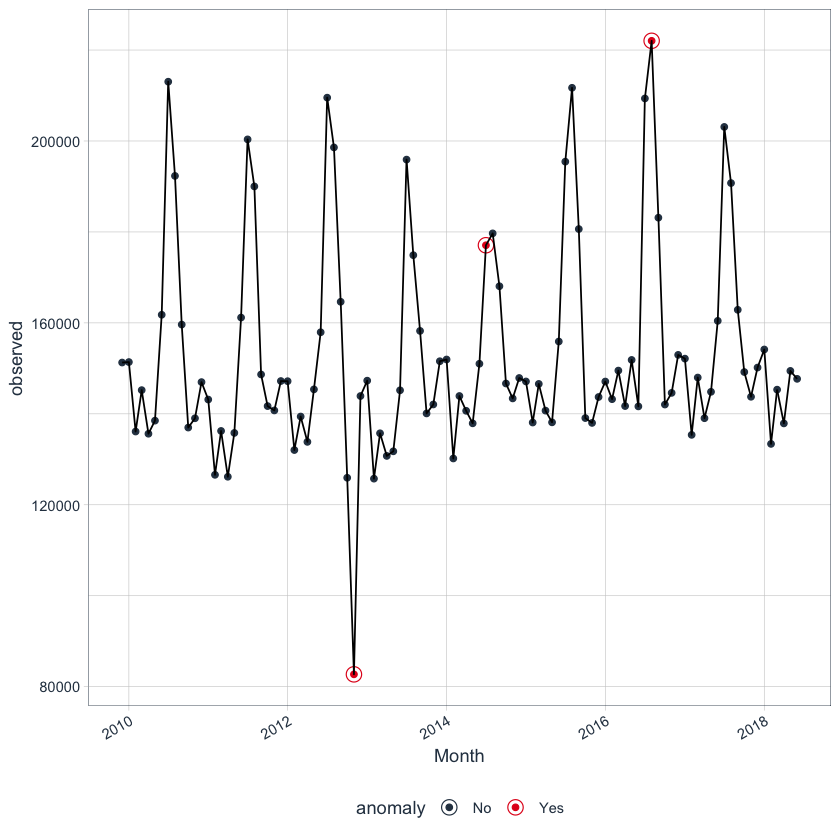

In [32]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

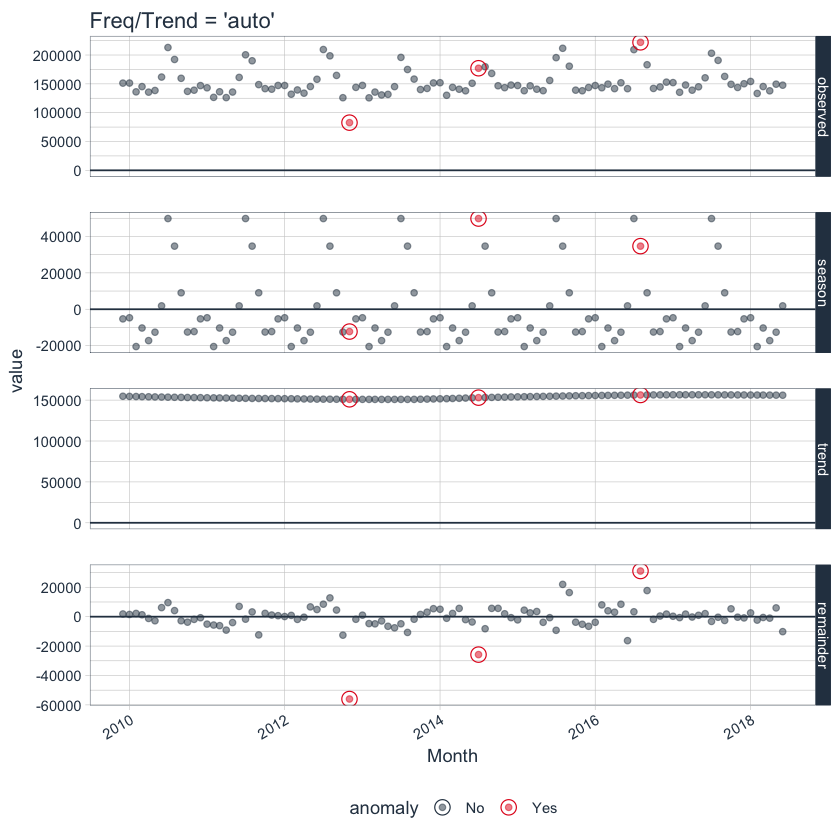

In [34]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'") 

p1

#### Example 2 - 3 missing values in the middle (works better than the Twitter library)

In [11]:
ts =  select(filter(tb, Building_Meter == '164.0 - BLD 01_96973681'), 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, merge = TRUE) %>%
    anomalize(remainder) %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


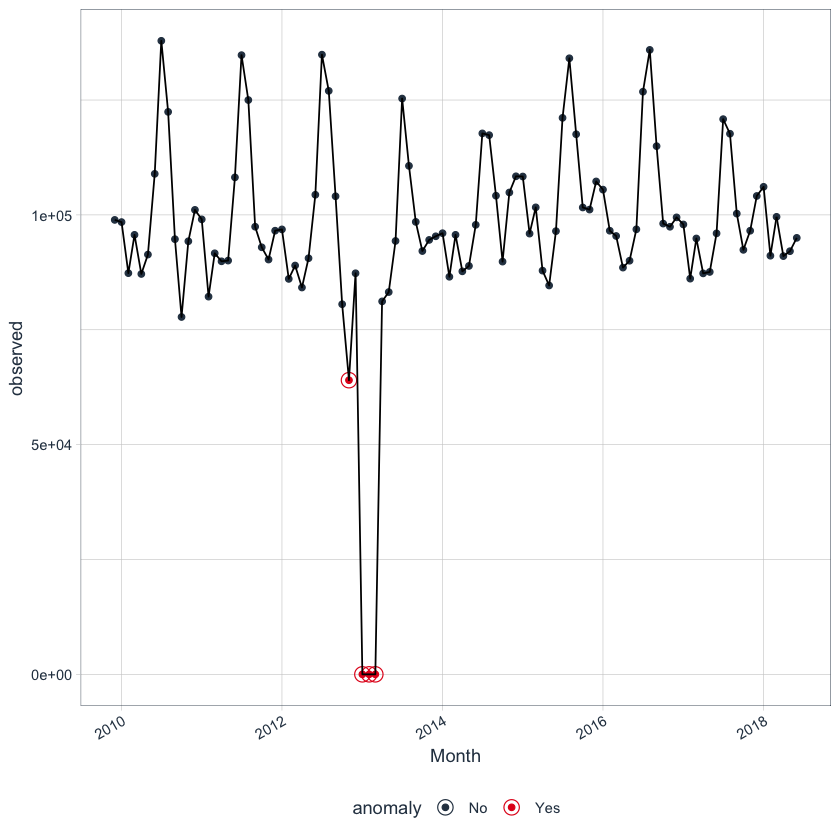

In [12]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

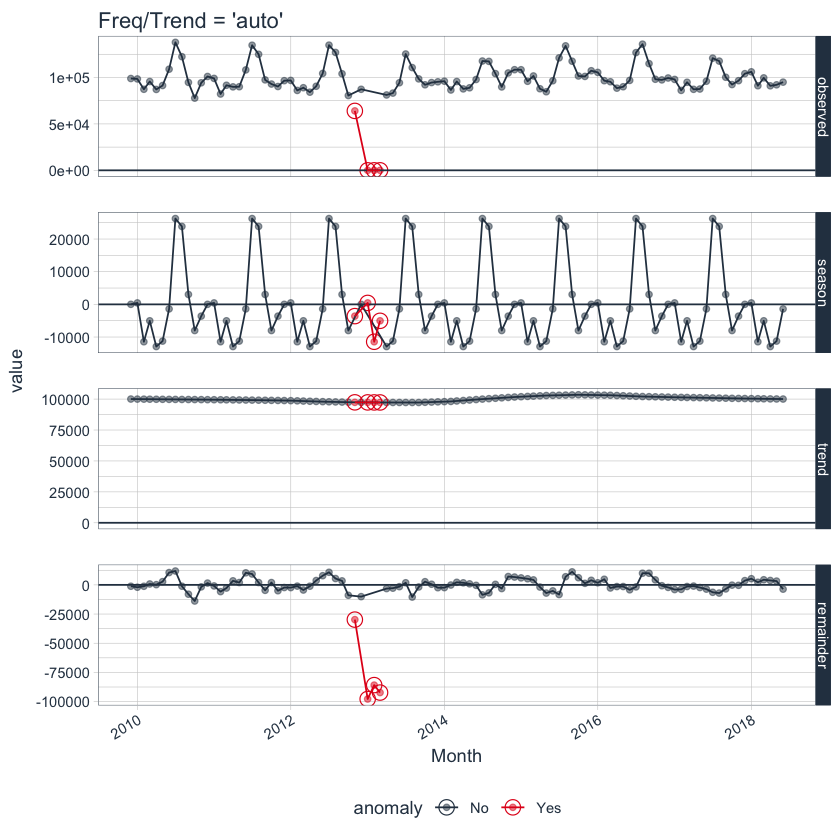

In [13]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'") + geom_line()

p1

#### Example 3 - only 12 points (doesn't work)

In [44]:
ts =  select(filter(tb, Building_Meter == '1.0 - BLD 04_8638820'), 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, merge = TRUE) %>%
    anomalize(remainder) %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 3 months
trend = 6 months


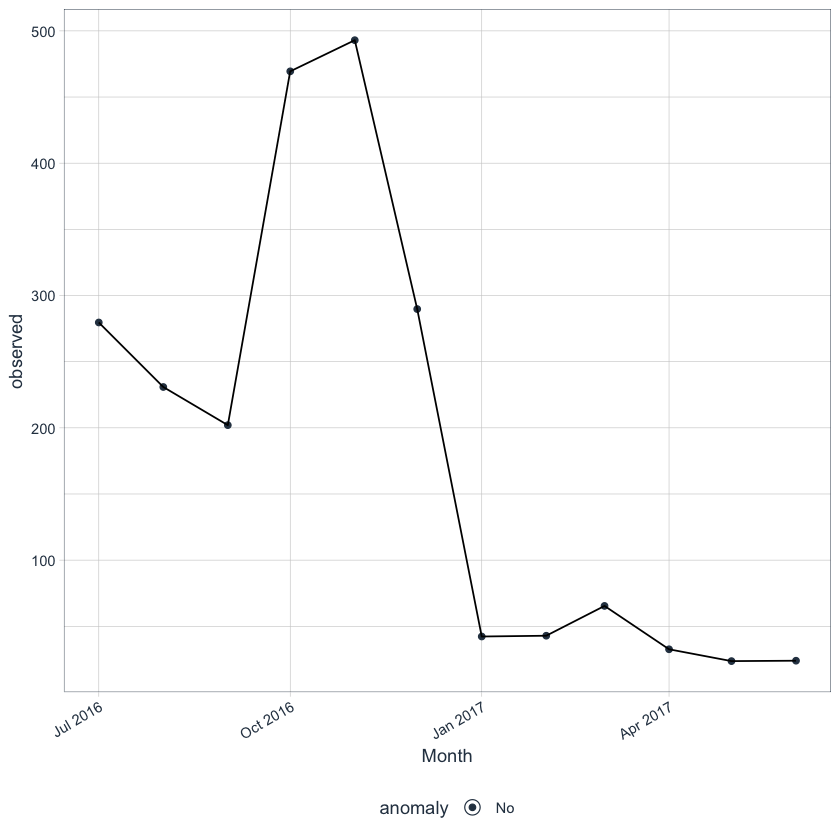

In [45]:
ts_anomalized %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

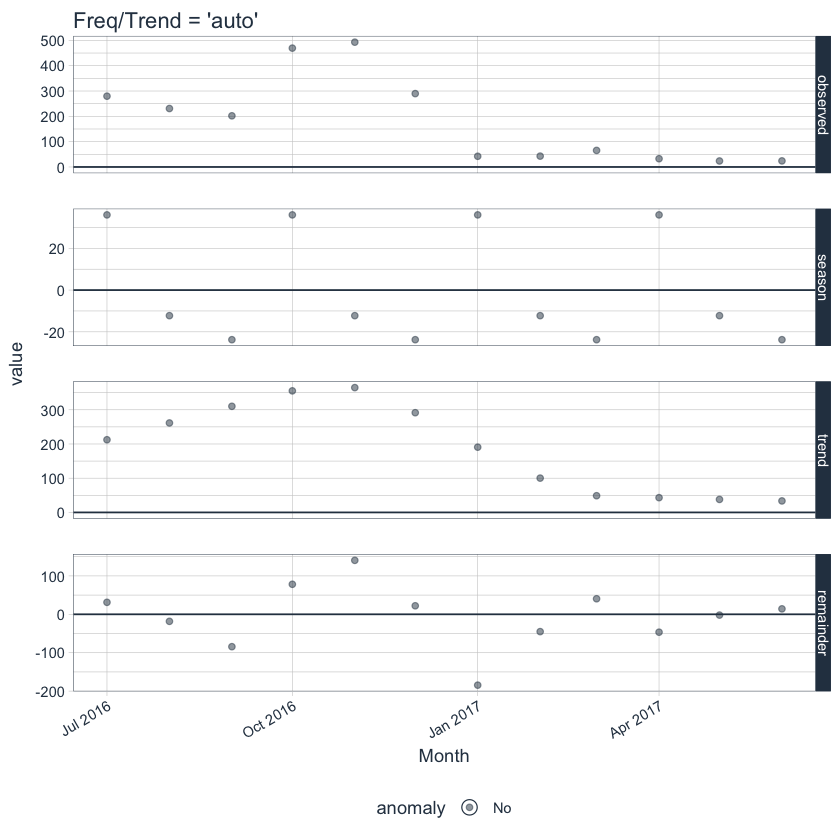

In [46]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

#### Loop through all accounts (with at least 3 years of data)

In [114]:
accounts = tb %>% group_by(Building_Meter) %>% summarise(counts = n())

accounts = filter(accounts, counts >= 36)$Building_Meter

In [120]:
length(accounts)

[1] 2355

In [121]:
points = c(NA, length(accounts))
anoamly_counts = c(NA, length(accounts))

In [124]:
start.time <- Sys.time()

for (i in 1:length(accounts)) {
    ts =  select(filter(tb, Building_Meter == accounts[i]), 'Month', 'Imputed_KWH')
    ts_anomalized <- ts %>%
        time_decompose(Imputed_KWH, merge = TRUE) %>%
        anomalize(remainder) %>%
        time_recompose()
    points[i] = dim(ts_anomalized)[1]
    anoamly_counts[i] = dim(filter(ts_anomalized, anomaly == 'Yes'))[1]
}

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting

frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Conv

frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 17 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 20 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freq

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Conver

frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freq

trend = 28.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10.5 months
trend = 20.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 45.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
tr

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 8 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 20 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 28.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 15 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 15 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 27 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequenc

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24 mon

frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 29 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequenc

frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index 

trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42

frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 46.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequenc

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Conver

frequency = 12 months
trend = 44.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freq

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months


Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

trend = 21.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting

frequency = 12 months
trend = 16 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
trend = 18.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
trend = 18.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 29 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

Time difference of 3.473603 mins

In [126]:
results = data.frame('points' = points, 'anomalies' = anoamly_counts)

results$perc = results$anomalies / results$points

[1] 0.184466019 0.184466019 0.126213592 0.135922330 0.165048544 0.126213592
   [7] 0.126213592 0.054794521 0.105263158 0.117647059 0.137254902 0.058823529
  [13] 0.068627451 0.198019802 0.196078431 0.141414141 0.049019608 0.117647059
  [19] 0.098039216 0.039215686 0.117647059 0.127450980 0.156862745 0.078431373
  [25] 0.078431373 0.000000000 0.200000000 0.000000000 0.077669903 0.048543689
  [31] 0.055555556 0.165048544 0.048543689 0.039215686 0.077669903 0.077669903
  [37] 0.104166667 0.058252427 0.077669903 0.106796117 0.197530864 0.075757576
  [43] 0.136363636 0.106060606 0.075757576 0.197916667 0.170000000 0.165048544
  [49] 0.079207921 0.097087379 0.009708738 0.019417476 0.173913043 0.106796117
  [55] 0.135922330 0.180851064 0.170212766 0.048543689 0.180851064 0.191489362
  [61] 0.191489362 0.078431373 0.019417476 0.000000000 0.029702970 0.118811881
  [67] 0.128571429 0.118811881 0.058252427 0.116504854 0.097087379 0.106796117
  [73] 0.067961165 0.165048544 0.128712871 0.137254902 0.000000000 0.184466019
  [79] 0.098039216 0.058252427 0.156862745 0.106796117 0.039603960 0.155339806
  [85] 0.155339806 0.067961165 0.135135135 0.166666667 0.019230769 0.126213592
  [91] 0.067961165 0.108108108 0.072164948 0.097087379 0.116504854 0.019417476
  [97] 0.038834951 0.009708738 0.087378641 0.078431373 0.155339806 0.097087379
 [103] 0.194174757 0.088235294 0.135922330 0.009708738 0.170000000 0.126213592
 [109] 0.106796117 0.087378641 0.048543689 0.194174757 0.089108911 0.165048544
 [115] 0.074074074 0.145631068 0.019417476 0.194174757 0.048543689 0.075757576
 [121] 0.081081081 0.126213592 0.058252427 0.048543689 0.087378641 0.116883117
 [127] 0.087378641 0.029126214 0.029126214 0.048543689 0.194174757 0.073529412
 [133] 0.065217391 0.128712871 0.129629630 0.086956522 0.128205128 0.158415842
 [139] 0.138613861 0.111111111 0.168316832 0.126582278 0.150000000 0.065789474
 [145] 0.112500000 0.151898734 0.152173913 0.148514851 0.155555556 0.120000000
 [151] 0.158415842 0.118811881 0.168316832 0.128712871 0.136986301 0.097087379
 [157] 0.061224490 0.142857143 0.038461538 0.135922330 0.048543689 0.019417476
 [163] 0.058252427 0.019417476 0.116504854 0.067961165 0.146341463 0.058252427
 [169] 0.130000000 0.194174757 0.200000000 0.125000000 0.187500000 0.187500000
 [175] 0.194174757 0.038834951 0.000000000 0.038834951 0.165048544 0.029126214
 [181] 0.019417476 0.013513514 0.019417476 0.058823529 0.077669903 0.048543689
 [187] 0.009708738 0.087378641 0.087378641 0.019417476 0.048543689 0.067961165
 [193] 0.090000000 0.048543689 0.029126214 0.049504950 0.130434783 0.198019802
 [199] 0.009900990 0.198019802 0.168316832 0.140000000 0.019801980 0.193877551
 [205] 0.029702970 0.168316832 0.198019802 0.019801980 0.009900990 0.099009901
 [211] 0.029702970 0.184210526 0.200000000 0.059405941 0.079207921 0.000000000
 [217] 0.198019802 0.049504950 0.029702970 0.079207921 0.148514851 0.198019802
 [223] 0.049504950 0.038834951 0.079207921 0.058252427 0.058252427 0.058252427
 [229] 0.038834951 0.038834951 0.058252427 0.038834951 0.048543689 0.029126214
 [235] 0.029126214 0.009708738 0.038834951 0.097087379 0.087378641 0.077669903
 [241] 0.038834951 0.194174757 0.000000000 0.019801980 0.090000000 0.070707071
 [247] 0.050000000 0.030303030 0.000000000 0.000000000 0.000000000 0.000000000
 [253] 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
 [259] 0.000000000 0.188405797 0.057971014 0.188405797 0.049504950 0.000000000
 [265] 0.020000000 0.144927536 0.188405797 0.173913043 0.173913043 0.188405797
 [271] 0.188405797 0.106796117 0.160919540 0.029702970 0.097087379 0.038834951
 [277] 0.067961165 0.067961165 0.014492754 0.043478261 0.100000000 0.117647059
 [283] 0.038834951 0.090909091 0.102272727 0.068181818 0.079545455 0.157303371
 [289] 0.102272727 0.068181818 0.149253731 0.056179775 0.079545455 0.079545455
 [295] 0.044943820 0.108108108 0.191489362 0.135922330 0.196078431 0.155339806
 [301] 0.000000000 0.059405941 0.186813187 0.00970873

In [133]:
head(results)

points,anomalies,perc
103,19,0.1844660
103,19,0.1844660
103,13,0.1262136
103,14,0.1359223
103,17,0.1650485
103,13,0.1262136


In [135]:
summary(results$perc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02913 0.07767 0.08518 0.13592 0.20000 

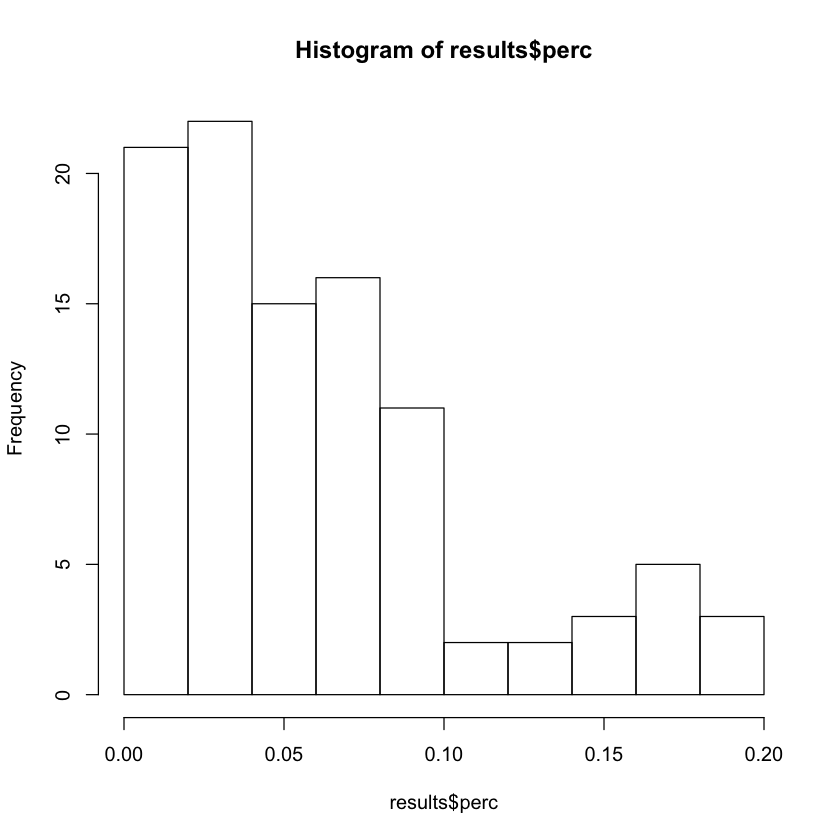

In [102]:
hist(results$perc)

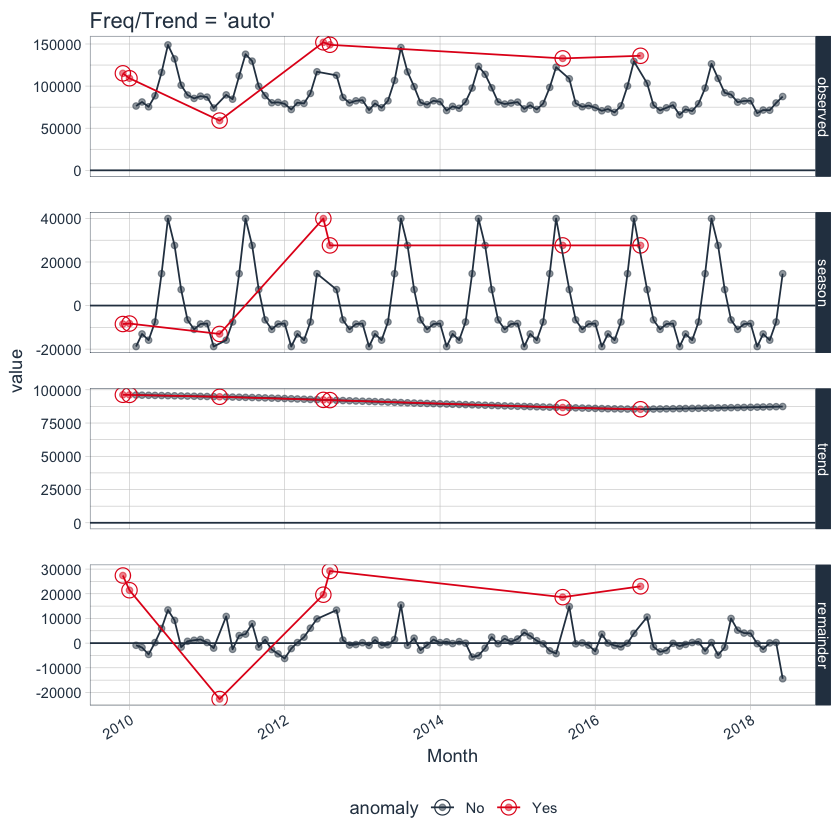

In [20]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'") + geom_line()

p1